In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dolly_cqa_df = pd.read_parquet('./data/dolly_cqa_prepared.parquet')
dolly_cqa_df

,instruction,context,response,category,text,embeddings_mini_lm,embeddings_bge_large,fk_score,fk_score_categ
0,When did Virgin Australia start operating?,"Virgin Australia, the trading name of Virgin A...",Virgin Australia commenced services on 31 Augu...,closed_qa,"### CONTEXT ###\nVirgin Australia, the trading...","[0.07990753650665283, -0.04975801706314087, 0....","[0.5005730390548706, -0.46779343485832214, -1....",9.131896,easy
1,When was Tomoaki Komorida born?,Komorida was born in Kumamoto Prefecture on Ju...,"Tomoaki Komorida was born on July 10,1981.",closed_qa,### CONTEXT ###\nKomorida was born in Kumamoto...,"[-0.011252421885728836, -0.04460098594427109, ...","[0.64762282371521, 0.43752172589302063, -0.047...",7.643152,easy
2,"Given a reference text about Lollapalooza, whe...",Lollapalooza /ˌlɒləpəˈluːzə/ (Lolla) is an ann...,Lollapalooze is an annual musical festival hel...,closed_qa,### CONTEXT ###\nLollapalooza /ˌlɒləpəˈluːzə/ ...,"[0.06580415368080139, -0.0366082526743412, 0.0...","[0.5144393444061279, 0.18275967240333557, -0.4...",11.617224,medium
3,Who was Kyle Van Zyl playing against when he s...,Van Zyl joined the Eastern Province Kings Acad...,Kyle Van Zyl was playing against Boland U21 wh...,closed_qa,### CONTEXT ###\nVan Zyl joined the Eastern Pr...,"[0.019957538694143295, 0.04702803120017052, -0...","[1.1888214349746704, 0.058644916862249374, -0....",11.474969,medium
4,Who was the first to record the Needles and Pi...,"""Needles and Pins"" is a rock song credited to ...",The first artist to record Needles and Pins so...,closed_qa,"### CONTEXT ###\n""Needles and Pins"" is a rock ...","[-0.08916875720024109, 0.0042908587493002415, ...","[-0.08973768353462219, -0.17643515765666962, 0...",9.573611,easy
...,...,...,...,...,...,...,...,...,...
1456,How many world championships has Max Verstappe...,"After winning the 2021 Abu Dhabi Grand Prix, V...",Max Verstappen has won 2 Formula One World Cha...,closed_qa,### CONTEXT ###\nAfter winning the 2021 Abu Dh...,"[0.044786978513002396, 0.0190593209117651, -0....","[0.5898312330245972, 0.14761556684970856, -0.4...",7.991569,easy
1457,What is the history of coffee?,The history of coffee dates back to centuries ...,Much of the early history of coffee was tied t...,closed_qa,### CONTEXT ###\nThe history of coffee dates b...,"[0.019176138564944267, 0.02772548422217369, -0...","[0.10451232641935349, 0.22819367051124573, -0....",11.447779,medium
1458,What are common florals found in Zigalga Natio...,Zigalga National Park (Russian: Национальный п...,Zigalga National Park has the majority of its ...,closed_qa,### CONTEXT ###\nZigalga National Park (Russia...,"[-0.026473581790924072, 0.09908297657966614, -...","[0.1897222250699997, 0.41683098673820496, 0.02...",12.950833,medium
1459,What is linux Bootloader,"A bootloader, also spelled as boot loader or c...",A bootloader is a program written in machine c...,closed_qa,"### CONTEXT ###\nA bootloader, also spelled as...","[-0.05690043047070503, 0.05346180498600006, -0...","[0.32251039147377014, -0.2482924461364746, 0.0...",19.799659,hard


In [3]:
def train_linear_regression_with_cv(df, embeddings_col, y_col):
    X = np.array(df[embeddings_col].tolist())
    X = X / np.linalg.norm(X, axis=1, keepdims=True)
    
    y = df[y_col].values
    
    kf = KFold(n_splits=7, shuffle=True, random_state=369)
    
    best_model = None
    best_error = float('inf')
    
    for train_index, val_index in kf.split(df):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        predictions = model.predict(X_val)
        error = mean_squared_error(y_val, predictions)
        
        if error < best_error:
            best_error = error
            best_model = model
    
    return best_model

In [4]:
clf = train_linear_regression_with_cv(df=dolly_cqa_df, embeddings_col='embeddings_mini_lm', y_col='fk_score')

In [5]:
def get_predictions(df, clf, embeddings_col, y_col):
    X = np.array(df[embeddings_col].tolist())
    X = X / np.linalg.norm(X, axis=1, keepdims=True)
    
    y = df[y_col].values

    y_pred = clf.predict(X)

    print('MSE:', mean_squared_error(y, y_pred))
    print('MAE:', mean_absolute_error(y, y_pred))
    print('R2:', r2_score(y, y_pred))

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y, y=y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

MSE: 3.636588083024375
MAE: 1.4695096306122626
R2: 0.5548973514213369


c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs

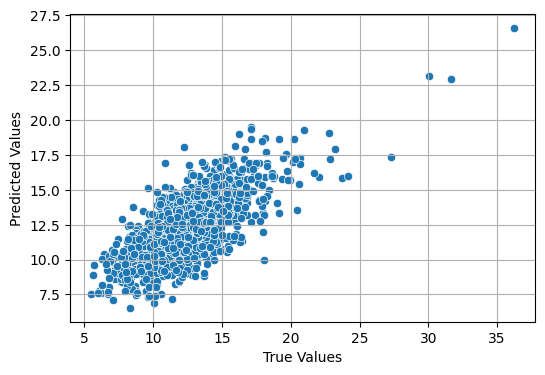

In [6]:
get_predictions(df=dolly_cqa_df, clf=clf, embeddings_col='embeddings_mini_lm', y_col='fk_score')

In [7]:
# dolly_cqa_df['score_easy'] = clf.predict_proba(X=np.array(dolly_cqa_df['embeddings_bge_large'].tolist()))[:,0]
# dolly_cqa_df['score_hard'] = clf.predict_proba(X=np.array(dolly_cqa_df['embeddings_bge_large'].tolist()))[:,1]
# dolly_cqa_df['score_medium'] = clf.predict_proba(X=np.array(dolly_cqa_df['embeddings_bge_large'].tolist()))[:,2]

# dolly_cqa_df['w_easy_embeddings'] = dolly_cqa_df['embeddings_bge_large'].apply(lambda x: x * clf.coef_[0])
# dolly_cqa_df['w_hard_embeddings'] = dolly_cqa_df['embeddings_bge_large'].apply(lambda x: x * clf.coef_[1])
# dolly_cqa_df['w_medium_embeddings'] = dolly_cqa_df['embeddings_bge_large'].apply(lambda x: x * clf.coef_[2])
# dolly_cqa_df['iw_easy_embeddings'] = dolly_cqa_df['embeddings_bge_large'].apply(lambda x: x / clf.coef_[0])
# dolly_cqa_df['iw_hard_embeddings'] = dolly_cqa_df['embeddings_bge_large'].apply(lambda x: x / clf.coef_[1])
# dolly_cqa_df['iw_medium_embeddings'] = dolly_cqa_df['embeddings_bge_large'].apply(lambda x: x / clf.coef_[2])

dolly_cqa_df['absolute_error'] = np.abs(np.array(dolly_cqa_df['fk_score']) - clf.predict(X=np.array(dolly_cqa_df['embeddings_mini_lm'].tolist())))
dolly_cqa_df['w_embeddings'] = dolly_cqa_df['embeddings_mini_lm'].apply(lambda x: x * clf.coef_)
dolly_cqa_df['iw_embeddings'] = dolly_cqa_df['embeddings_mini_lm'].apply(lambda x: x / clf.coef_)

In [8]:
def get_cluster_stats(df, cluster_col, score_col):
    return df.groupby(cluster_col).agg(
        score_mean=pd.NamedAgg(column=score_col, aggfunc='mean'), 
        score_std =pd.NamedAgg(column=score_col, aggfunc='std')
    ).reset_index(drop=False).rename(columns={cluster_col: 'cluster_id'})

n_clusters = 50
seed=0
uw_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['embeddings_mini_lm']])
w_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['w_embeddings']])
iw_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['iw_embeddings']])

dolly_cqa_df['uw_kmeans'] = uw_kmeans.labels_
dolly_cqa_df['w_kmeans'] = w_kmeans.labels_
dolly_cqa_df['iw_kmeans'] = iw_kmeans.labels_

# cs_unweighted = get_cluster_stats(dd2, 'unweighted_kmeans', 'score')
# cs_weighted = get_cluster_stats(dd2, 'weighted_kmeans', 'score')
# cs_inverse_weighted = get_cluster_stats(dd2, 'inverse_weighted_kmeans', 'score')

c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [9]:
cluster_df = dolly_cqa_df[['uw_kmeans', 'w_kmeans', 'iw_kmeans', 'absolute_error']]
cluster_df = pd.melt(cluster_df, id_vars=['absolute_error'], var_name='weighting', value_name='cluster_id')
cluster_df = cluster_df.groupby(["weighting", "cluster_id"]).mean().reset_index()

[Text(0, 0.5, '')]

c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs

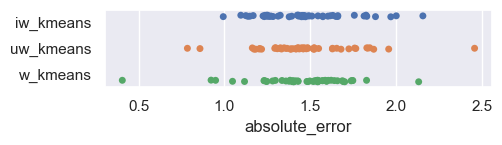

In [10]:
sns.set(rc={"figure.figsize":(5, 1)})
ax = sns.stripplot(x='absolute_error', y='weighting', data=cluster_df, jitter=True, hue='weighting', dodge=True, legend=False)
ax.set(ylabel=None)

In [11]:
cluster_df[['weighting', 'absolute_error']].groupby('weighting').std() # standard deviation of mean scores across clusters

,absolute_error
weighting,
iw_kmeans,0.254102
uw_kmeans,0.274293
w_kmeans,0.267141


c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs

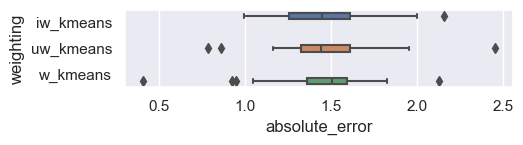

In [12]:
g = sns.boxplot(x='absolute_error', y ='weighting', data = cluster_df, hue ='weighting')
g.legend([],[], frameon=False)